### Unsupervised Analysis of Congressional Laws

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


#gensim
from gensim import corpora, models, similarities, matutils

#sklearn
from sklearn.feature_extraction.text import (CountVectorizer, 
                                             TfidfTransformer,
                                             TfidfVectorizer)
from sklearn.cluster import KMeans
from sklearn.decomposition import (NMF,
                                   TruncatedSVD)
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE

__Import data__

In [2]:
laws_df = pd.read_csv('all_laws.csv',index_col=0)

In [3]:
laws_names = list(laws_df.index)
laws_list = laws_df['text'].tolist()

__Import Law Summary Data__

In [4]:
laws_summarys = pd.read_csv('laws_summary.csv')

__ Import Custom Stop Words__

In [7]:
custom_stopwords_df = pd.read_csv('custom_stopwords_more.csv')
custom_sw = frozenset(custom_stopwords_df.iloc[:,1])

In [8]:
custom_sw

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'amended',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'ante',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'april',
           'are',
           'around',
           'as',
           'at',
           'august',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',

__Count Vectorizer__

In [9]:
count_vectorizer = CountVectorizer(ngram_range=(0, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]{3,100}\\b",
                                   max_df=0.8,
                                   min_df = 50)
count_vectorizer.fit(laws_list)



CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=50,
        ngram_range=(0, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='\\b[a-z][a-z]{3,100}\\b',
        tokenizer=None, vocabulary=None)

In [10]:
# Create the term-document matrix
# Transpose it so the terms are the rows
counts = count_vectorizer.transform(laws_list).transpose()

In [11]:
np.shape(counts)

(17274, 3896)

__Convert to gensim__

We need to convert our sparse `scipy` matrix to a `gensim`-friendly object called a Corpus:

In [10]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(counts)

__Map matrix rows to words (tokens)__

We need to save a mapping (dict) of row id to word (token) for later use by gensim:

In [11]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [12]:
len(id2word)

17274

## LDA
At this point we can simply plow ahead in creating an LDA model.  It requires our corpus of word counts, mapping of row ids to words, and the number of topics (3).

In [13]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=3)

In [14]:
lda.print_topics(num_words=20)

[(0,
  '0.010*"subsection" + 0.009*"paragraph" + 0.008*"secretary" + 0.007*"inserting" + 0.007*"amended" + 0.006*"striking" + 0.006*"year" + 0.006*"date" + 0.005*"general" + 0.005*"subparagraph" + 0.005*"title" + 0.005*"following" + 0.004*"state" + 0.004*"federal" + 0.004*"term" + 0.004*"plan" + 0.004*"described" + 0.004*"respect" + 0.003*"information" + 0.003*"period"'),
 (1,
  '0.012*"defense" + 0.011*"secretary" + 0.009*"subsection" + 0.007*"title" + 0.006*"department" + 0.006*"program" + 0.006*"report" + 0.005*"paragraph" + 0.005*"national" + 0.005*"year" + 0.005*"military" + 0.005*"amended" + 0.004*"inserting" + 0.004*"following" + 0.004*"section title" + 0.004*"striking" + 0.004*"fiscal" + 0.004*"fiscal year" + 0.004*"date" + 0.004*"general"'),
 (2,
  '0.009*"state" + 0.008*"secretary" + 0.008*"inserting" + 0.007*"subsection" + 0.007*"striking" + 0.007*"program" + 0.007*"paragraph" + 0.006*"year" + 0.005*"education" + 0.005*"amended" + 0.005*"title" + 0.005*"general" + 0.005*"fis

In [15]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]
lda_corpus

In [16]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

In [17]:
len(lda_docs)

3896

In [18]:
lda_docs[900]

[(0, 0.83333352937096972), (3, 0.16002046880759804)]

## NMF

In [12]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),  
                                   stop_words = custom_sw, 
                                   token_pattern="\\b[a-z][a-z]{2,100}\\b",
                                   max_df = 0.90,
                                   min_df = 50)

In [13]:
dtm = vectorizer.fit_transform(laws_list) 
#pd.DataFrame(dtm.toarray(), index=laws_names, columns=vectorizer.get_feature_names()).head(10)

In [14]:
dtm

<3896x16774 sparse matrix of type '<class 'numpy.float64'>'
	with 2398375 stored elements in Compressed Sparse Row format>

In [15]:
num_groups = 20
nmf_model = NMF(num_groups )
dtm_nmf = nmf_model.fit_transform(dtm)
dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf)

In [16]:
features = vectorizer.get_feature_names()
print("These are the documents extracted from the data and their respective topics:")
print('')
#nmf.components_


num_words = 20
for topicidx, topic in enumerate(nmf_model.components_):
    
    print('Topic: ' + str(topicidx))
    print("Keywords: " + " ".join([features[i] for i in topic.argsort()[:-1*num_words-1:-1]]) )# 
    print('')

These are the documents extracted from the data and their respective topics:

Topic: 0
Keywords: post office post facility service located postal facility united postal service states postal reference located office references office approved service office note office designation states facility facility referred designate facility designation facility street

Topic: 1
Keywords: health secretary state program shall services fiscal research year education care information fiscal year grant secretary shall programs report including assistance federal

Topic: 2
Keywords: courthouse states courthouse courthouse located courthouse note courthouse references courthouse approved courthouse referred street designate united reference designation united assembled designation infrastructure congressional comm transportation states united located act designate regulation document reference law map regulation

Topic: 3
Keywords: land secretary conveyance forest federal land county national forest 

__Investigate whether Topics identified match title__

In [17]:
def rank_df(df,rank,num_groups):
    coln = 'MAX' + str(rank) 
    sortID = np.argpartition(
        -df[list(np.arange(0,num_groups))].values,rank,axis=1)[:,rank-1]
    df[coln] = df.columns[sortID]

In [18]:
nmf_df = pd.DataFrame(dtm_nmf, index = laws_df.index)

rank_df(nmf_df,1,num_groups)
rank_df(nmf_df,2,num_groups)
rank_df(nmf_df,3,num_groups)
nmf_df.reset_index(inplace=True)
nmf_df.rename(columns={'index':'id'},inplace=True)

nmf_df = nmf_df.merge(laws_summarys[['id','title']],on = 'id',how = 'left')

In [19]:
# Random View of Laws
pd.options.display.max_colwidth = 100
nmf_df[['id','title','MAX1','MAX2','MAX3']].iloc[
    np.random.choice(np.arange(0,len(laws_list)),
                     size = 10,
                     replace = False)]

,id,title,MAX1,MAX2,MAX3
113,c104publ200,H.R.4018 - To make technical corrections in the Federal Oil and Gas Royalty Management Act of 19...,4,17,19
1746,c109publ200,H.R.4107 - To designate the facility of the United States Postal Service located at 1826 Pennsyl...,7,0,12
3076,c112publ205,H.R.915 - Jaime Zapata Border Enforcement Security Task Force Act 112th Congress...,16,1,19
2671,c111publ186,H.R.4238 - To designate the facility of the United States Postal Service located at 930 39th Ave...,7,0,9
1075,c107publ45,S.1424 - A bill to amend the Immigration and Nationality Act to provide permanent authority for ...,8,19,11
2972,c112publ111,H.R.2244 - To designate the facility of the United States Postal Service located at 67 Castle St...,0,7,12
2257,c110publ227,H.R.5715 - Ensuring Continued Access to Student Loans Act of 2008 110th Congress...,1,11,19
757,c106publ9,H.R.68 - Small Business Investment Improvement Act of 1999 106th Congress (1999-...,15,19,14
3539,c114publ100,"H.J.Res.78 - Making further continuing appropriations for fiscal year 2016, and for other purpos...",4,18,6
1384,c108publ323,"H.R.4654 - To reauthorize the Tropical Forest Conservation Act of 1998 through fiscal year 2007,...",5,11,11


## Try LSA too!

In [20]:
vectorizer2 = TfidfVectorizer(
    ngram_range=(1,2),  
    stop_words = custom_sw, 
    token_pattern="\\b[a-z][a-z]{2,100}\\b",
    max_df = 0.80,
    min_df = 50)

dtm2 = vectorizer2.fit_transform(laws_list) 

In [21]:
# Fit LSA. Use algorithm = “randomized” for large datasets 

num_groups2 = 15
lsa_model = TruncatedSVD(num_groups2, algorithm = 'randomized')
dtm_lsa = lsa_model.fit_transform(dtm2)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [22]:
features = vectorizer2.get_feature_names()
print("These are the documents extracted from the data and their respective topics:")
print('')
#nmf.components_


num_words = 20
for topicidx, topic in enumerate(lsa_model.components_):
    
    print('Topic: ' + str(topicidx))
    print("Keywords: " + " ".join([features[i] for i in topic.argsort()[:-1*num_words-1:-1]]) )# 
    print('')

These are the documents extracted from the data and their respective topics:

Topic: 0
Keywords: post office post office building building facility service located facility united states postal postal service postal reference located service states facility facility referred designation facility designate facility map regulation law map paper record

Topic: 1
Keywords: secretary year state federal fiscal provided program available national funds fiscal year date general following including services department health report security

Topic: 2
Keywords: courthouse states courthouse federal building building federal courthouse located courthouse note courthouse references courthouse approved infrastructure congressional courthouse referred street land comm transportation building located transportation infrastructure assembled designation reference designate federal designate united

Topic: 3
Keywords: land secretary national park lands conveyance forest federal land resources boundary co

In [23]:
lsa_df = pd.DataFrame(dtm_lsa, index = laws_df.index)

In [24]:
rank_df(lsa_df,1,num_groups=num_groups2)
rank_df(lsa_df,2,num_groups=num_groups2)
rank_df(lsa_df,3,num_groups=num_groups2)
lsa_df.reset_index(inplace=True)
lsa_df.rename(columns={'index':'id'},inplace=True)

lsa_df = lsa_df.merge(laws_summarys[['id','title']],on = 'id',how = 'left')

In [25]:
# Random View of Laws
pd.options.display.max_colwidth = 100
nmf_df[['id','title','MAX1','MAX2','MAX3']].iloc[
    np.random.choice(np.arange(0,len(laws_list)),
                     size = 10,
                     replace = False)]

,id,title,MAX1,MAX2,MAX3
2316,c110publ280,H.R.802 - Maritime Pollution Prevention Act of 2008 110th Congress (2007-2008),19,1,1
1627,c108publ94,S.233 - Coltsville Study Act of 2003 108th Congress (2003-2004),13,1,16
3511,c113publ76,"H.R.3547 - Consolidated Appropriations Act, 2014 113th Congress (2013-2014)",5,16,1
2006,c109publ435,H.R.6407 - Postal Accountability and Enhancement Act 109th Congress (2005-2006),9,0,19
795,c107publ132,H.R.3348 - To designate the National Foreign Affairs Training Center as the George P. Shultz Nat...,13,6,16
624,c105publ361,S.459 - Native American Programs Act Amendments of 1998 105th Congress (1997-1998),11,18,11
1298,c108publ246,H.R.3300 - To designate the facility of the United States Postal Service located at 15500 Pearl ...,7,0,8
3735,c114publ278,H.R.710 - To require the Secretary of Homeland Security to prepare a comprehensive security asse...,16,1,19
2327,c110publ290,H.R.3564 - Regulatory Improvement Act of 2007 110th Congress (2007-2008),11,4,5
583,c105publ324,H.R.4679 - Antimicrobial Regulation Technical Corrections Act of 1998 105th Cong...,19,1,19


__TSNE Visualization (NMF)__

In [26]:
np.shape(dtm_nmf)

(3896, 20)

In [27]:
tsne_model = TSNE(learning_rate=300,
                  perplexity=50,
                  early_exaggeration=4.0,
                  n_iter=5000,
                  verbose=2,
                  random_state = 101)

tsne_nmf = tsne_model.fit_transform(dtm_nmf)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3896
[t-SNE] Computed conditional probabilities for sample 2000 / 3896
[t-SNE] Computed conditional probabilities for sample 3000 / 3896
[t-SNE] Computed conditional probabilities for sample 3896 / 3896
[t-SNE] Mean sigma: 0.067331
[t-SNE] Iteration 25: error = 1.7240351, gradient norm = 0.0004169
[t-SNE] Iteration 25: gradient norm 0.000417. Finished.
[t-SNE] Iteration 50: error = 1.5572103, gradient norm = 0.0077149
[t-SNE] Iteration 75: error = 1.4542772, gradient norm = 0.0056593
[t-SNE] Iteration 100: error = 1.4318122, gradient norm = 0.0053585
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.431812
[t-SNE] Iteration 125: error = 1.2834164, gradient norm = 0.0036906
[t-SNE] Iteration 150: error = 1.2379627, gradient norm = 0.0033191
[t-SNE] Iteration 175: error = 1.2267942, gradient norm = 0.0032327
[t-SNE] Iteration 

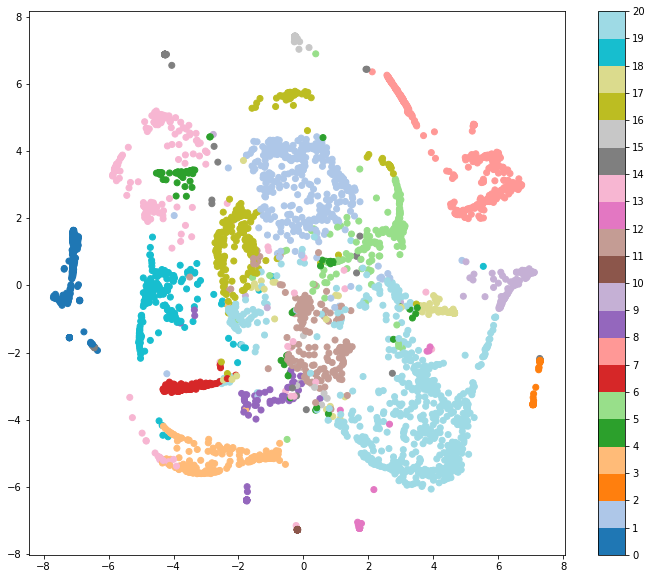

In [28]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_nmf[:,0], tsne_nmf[:,1], c=nmf_df.MAX1, cmap=plt.cm.get_cmap("tab20", num_groups))
plt.colorbar(ticks=range(num_groups+1))
plt.clim(0, num_groups)
plt.show()

__TSNE Visualization (LSA)__

tsne_model = TSNE(learning_rate=300,
                  perplexity=50,
                  n_iter=5000,
                  verbose=2,random_state = 101)

tsne_lsa = tsne_model.fit_transform(dtm_lsa)

In [29]:
tsne_model = TSNE(learning_rate=200,
                  perplexity=50,
                  n_iter=5000,
                  verbose=2,random_state = 101)

tsne_lsa = tsne_model.fit_transform(dtm_lsa)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3896
[t-SNE] Computed conditional probabilities for sample 2000 / 3896
[t-SNE] Computed conditional probabilities for sample 3000 / 3896
[t-SNE] Computed conditional probabilities for sample 3896 / 3896
[t-SNE] Mean sigma: 0.071051
[t-SNE] Iteration 25: error = 1.7721850, gradient norm = 0.0000738
[t-SNE] Iteration 25: gradient norm 0.000074. Finished.
[t-SNE] Iteration 50: error = 1.7542493, gradient norm = 0.0132946
[t-SNE] Iteration 75: error = 1.6654365, gradient norm = 0.0096930
[t-SNE] Iteration 100: error = 1.6407571, gradient norm = 0.0086653
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.640757
[t-SNE] Iteration 125: error = 1.4875336, gradient norm = 0.0050154
[t-SNE] Iteration 150: error = 1.4424165, gradient norm = 0.0043974
[t-SNE] Iteration 175: error = 1.4313351, gradient norm = 0.0042656
[t-SNE] Iteration 

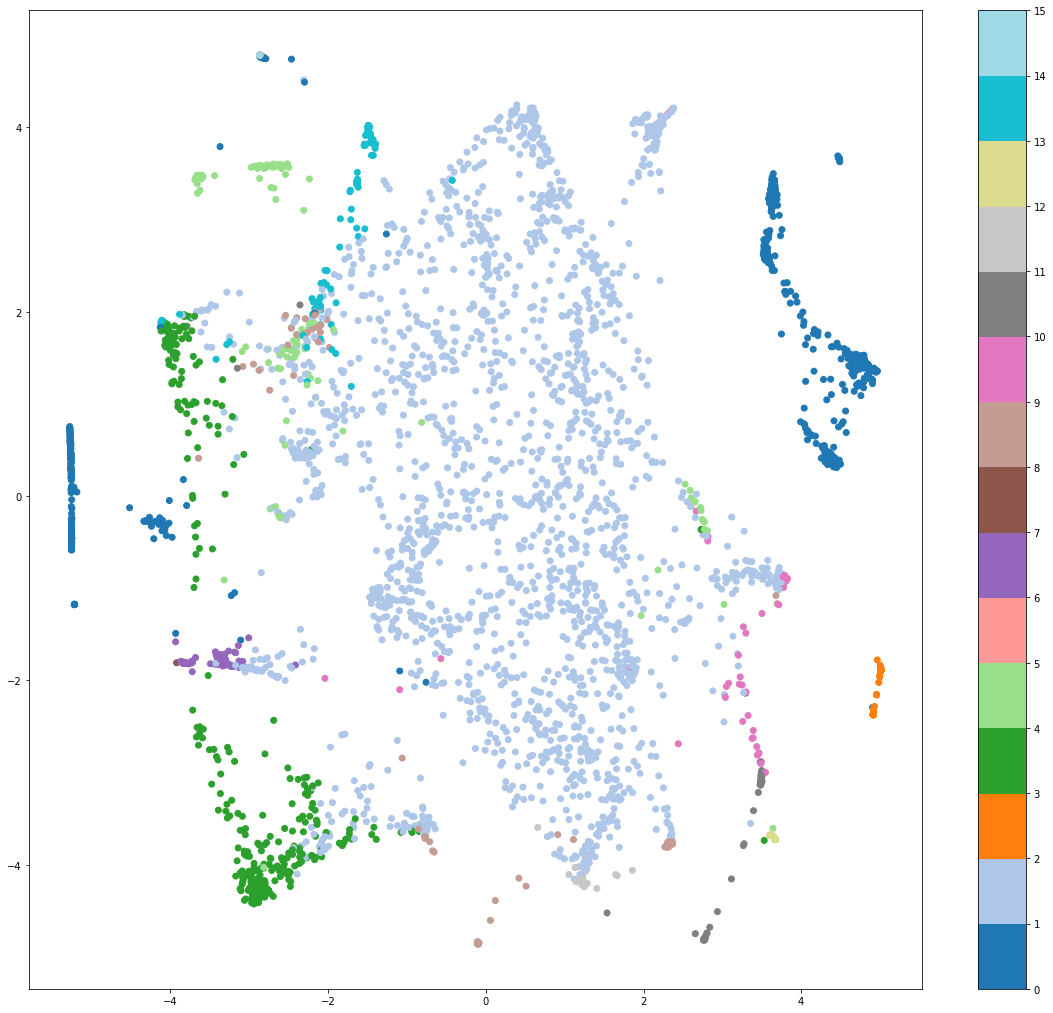

In [30]:
plt.figure(figsize=(20,18))
plt.scatter(tsne_lsa[:,0],
            tsne_lsa[:,1], 
            c=lsa_df.MAX1, 
            cmap=plt.cm.get_cmap("tab20",
                                 num_groups2))
plt.colorbar(ticks=range(num_groups2+1))
plt.clim(0, num_groups2)
plt.show()